# Flower Classification using CNN
This notebook implements a comprehensive flower classification system with various hyperparameter experiments.

## Assignment Overview
1. Download and preprocess flower dataset
2. Train CNN models with different configurations
3. Analyze performance across multiple experiments
4. Compare with MNIST model from Assignment 4

In [5]:
!pip install kagglehub

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.7.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Set Dataset Path
Dataset is located in the flowers directory

In [2]:
# Set path to the flowers dataset
path = '/home/Assignment-05/flowers'

print(f"Dataset path: {path}")
print(f"Contents: {os.listdir(path)}")

Dataset path: /home/Assignment-05/flowers
Contents: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## 3. Load and Preprocess Images
- Resize images to 80×80 pixels
- Convert to grayscale
- Normalize pixel values

In [3]:
def load_and_preprocess_images(data_path, img_size=(80, 80), grayscale=True, reduce_size=False):
    """
    Load and preprocess flower images
    
    Parameters:
    - data_path: Path to the dataset
    - img_size: Target size for images (default: 80x80)
    - grayscale: Convert to grayscale if True (default: True)
    - reduce_size: Reduce training set to 1/5 if True
    
    Returns:
    - X: Preprocessed images
    - y: Labels
    - class_names: List of class names
    """
    
    # Class names (matching the actual folder names)
    class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
    
    images = []
    labels = []
    
    print(f"Loading images from: {data_path}")
    
    for label_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        
        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist!")
            continue
            
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"Loading {len(image_files)} images from {class_name}...")
        
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            
            try:
                # Read image
                img = cv2.imread(img_path)
                
                if img is None:
                    continue
                
                # Resize
                img = cv2.resize(img, img_size)
                
                # Convert to grayscale if needed
                if grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                images.append(img)
                labels.append(label_idx)
                
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    
    # Convert to numpy arrays
    X = np.array(images, dtype='float32')
    y = np.array(labels)
    
    # Normalize pixel values
    X = X / 255.0
    
    # Add channel dimension for grayscale
    if grayscale and len(X.shape) == 3:
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    
    print(f"\nTotal images loaded: {len(X)}")
    print(f"Image shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    
    # Print class distribution
    for i, class_name in enumerate(class_names):
        count = np.sum(y == i)
        print(f"{class_name}: {count} images")
    
    # Shuffle the data
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Reduce size if needed (to 1/5)
    if reduce_size:
        reduce_count = len(X) // 5
        X = X[:reduce_count]
        y = y[:reduce_count]
        print(f"\nReduced dataset size to: {len(X)} images")
    
    return X, y, class_names

# Load grayscale images
X, y, class_names = load_and_preprocess_images(path, grayscale=True, reduce_size=False)

Loading images from: /home/Assignment-05/flowers
Loading 764 images from daisy...
Loading 1052 images from dandelion...
Loading 784 images from rose...
Loading 733 images from sunflower...
Loading 984 images from tulip...

Total images loaded: 4317
Image shape: (4317, 80, 80, 1)
Labels shape: (4317,)
daisy: 764 images
dandelion: 1052 images
rose: 784 images
sunflower: 733 images
tulip: 984 images


## 4. Visualize Sample Images

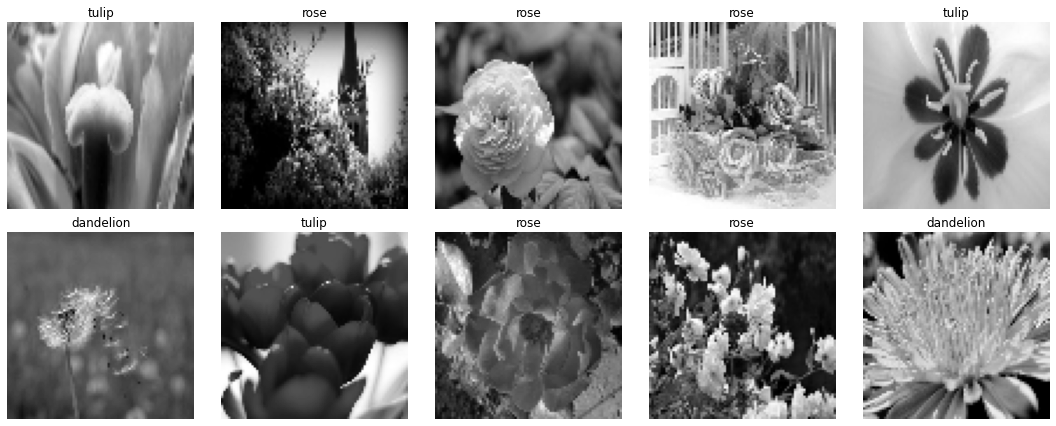

In [4]:
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f'{class_names[y[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Split Data into Train and Test Sets (90:10 ratio)

In [5]:
# Split data into train and test sets (90:10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"\nTraining set (categorical): {y_train_cat.shape}")
print(f"Test set (categorical): {y_test_cat.shape}")

Training set: (3885, 80, 80, 1), (3885,)
Test set: (432, 80, 80, 1), (432,)

Training set (categorical): (3885, 5)
Test set (categorical): (432, 5)


## 6. CNN Model Building Functions

In [6]:
def build_cnn_model(input_shape, 
                    kernel_sizes=[3, 3, 3], 
                    filters=[16, 32, 64],
                    pooling_type='max',
                    activation='relu',
                    num_fc_layers=1,
                    regularization='dropout',
                    dropout_rate=0.1,
                    use_batch_norm=False,
                    num_classes=5):
    """
    Build a CNN model with customizable hyperparameters
    
    Parameters:
    - input_shape: Shape of input images
    - kernel_sizes: List of kernel sizes for each conv layer
    - filters: List of filter counts for each conv layer
    - pooling_type: 'max' or 'average'
    - activation: Activation function ('relu', 'sigmoid', 'leaky_relu')
    - num_fc_layers: Number of fully connected layers after flatten
    - regularization: 'dropout', 'batch_norm', or 'both'
    - dropout_rate: Dropout rate
    - use_batch_norm: Use batch normalization
    - num_classes: Number of output classes
    
    Returns:
    - model: Compiled Keras model
    """
    
    model = models.Sequential()
    
    # Convolution layers
    for i, (kernel_size, num_filters) in enumerate(zip(kernel_sizes, filters)):
        if i == 0:
            model.add(layers.Conv2D(num_filters, (kernel_size, kernel_size), 
                                   padding='same', input_shape=input_shape))
        else:
            model.add(layers.Conv2D(num_filters, (kernel_size, kernel_size), 
                                   padding='same'))
        
        # Batch normalization (except for first layer if specified)
        if use_batch_norm and i > 0:
            model.add(layers.BatchNormalization())
        
        # Activation
        if activation == 'relu':
            model.add(layers.Activation('relu'))
        elif activation == 'sigmoid':
            model.add(layers.Activation('sigmoid'))
        elif activation == 'leaky_relu':
            model.add(layers.LeakyReLU(alpha=0.01))
        
        # Pooling
        if pooling_type == 'max':
            model.add(layers.MaxPooling2D((2, 2)))
        else:
            model.add(layers.AveragePooling2D((2, 2)))
        
        # Dropout
        if regularization in ['dropout', 'both']:
            model.add(layers.Dropout(dropout_rate))
    
    # Flatten
    model.add(layers.Flatten())
    
    # Fully connected layers
    for i in range(num_fc_layers):
        units = 128 if i == 0 else 64
        model.add(layers.Dense(units))
        
        if activation == 'relu':
            model.add(layers.Activation('relu'))
        elif activation == 'sigmoid':
            model.add(layers.Activation('sigmoid'))
        elif activation == 'leaky_relu':
            model.add(layers.LeakyReLU(alpha=0.01))
        
        if regularization in ['dropout', 'both']:
            model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# Function to train and evaluate model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, 
                       epochs=16, batch_size=32, experiment_name="Experiment"):
    """
    Train and evaluate a model
    
    Returns:
    - history: Training history
    - test_accuracy: Test accuracy
    - test_loss: Test loss
    - predictions: Model predictions on test set
    - train_time: Training time in seconds
    """
    
    print(f"\n{'='*50}")
    print(f"{experiment_name}")
    print(f"{'='*50}")
    print(f"Model Summary:")
    model.summary()
    
    # Count trainable parameters
    trainable_params = model.count_params()
    print(f"\nTrainable parameters: {trainable_params:,}")
    
    # Train model
    start_time = time.time()
    history = model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_split=0.1,
                       verbose=1)
    train_time = time.time() - start_time
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Predictions
    predictions = model.predict(X_test, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    
    return history, test_accuracy, test_loss, predictions, train_time, f1

# Function to plot training history
def plot_history(history, experiment_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{experiment_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{experiment_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, experiment_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{experiment_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return cm

print("Model building functions defined successfully!")

Model building functions defined successfully!


## 7. Experiment A: Convolution Kernel Size Analysis
Testing different kernel size combinations with:
- 3 Convolution Layers
- Filters: [16, 32, 64]
- Max Pooling
- ReLU Activation
- 1 Fully Connected Layer
- Dropout of 0.1


############################################################
Running A1: (3×3, 3×3, 3×3)
############################################################

A1: (3×3, 3×3, 3×3)
Model Summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_16 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 32)        4640      

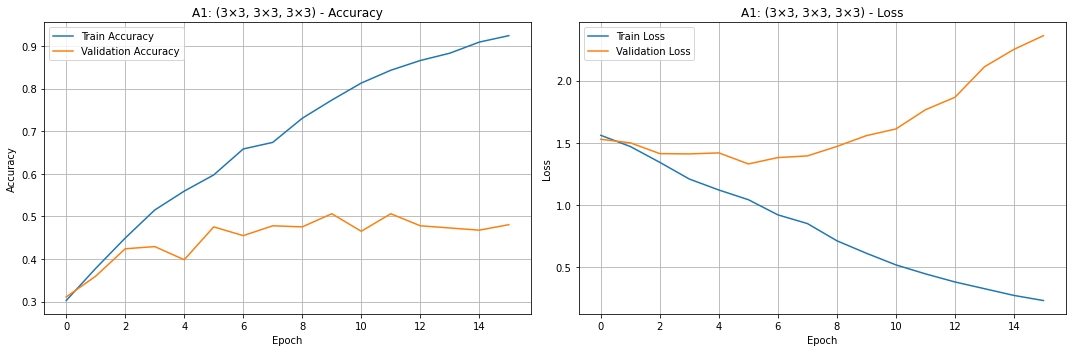

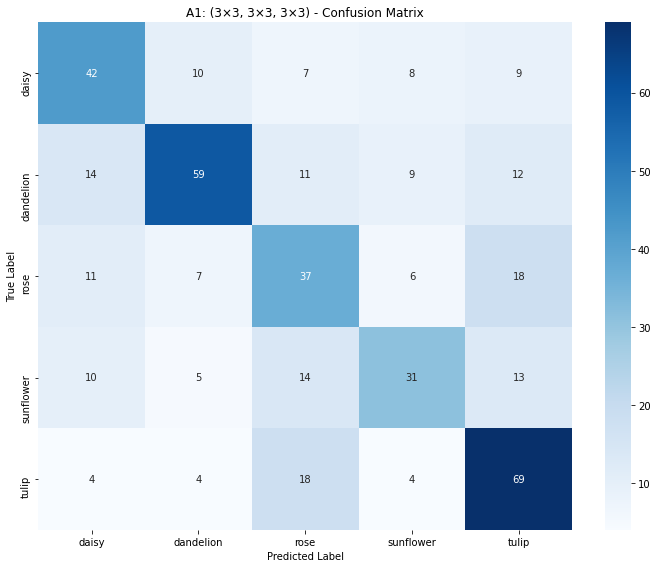


############################################################
Running A2: (3×3, 3×3, 5×5)
############################################################

A2: (3×3, 3×3, 5×5)
Model Summary:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_20 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 40, 32)        4640      

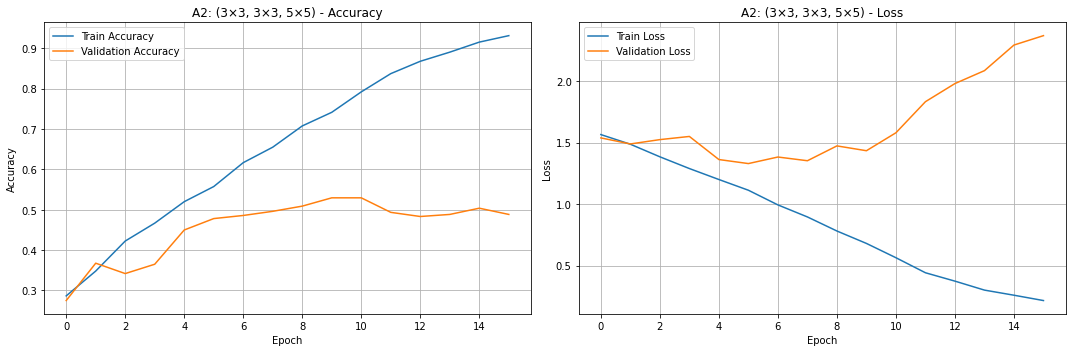

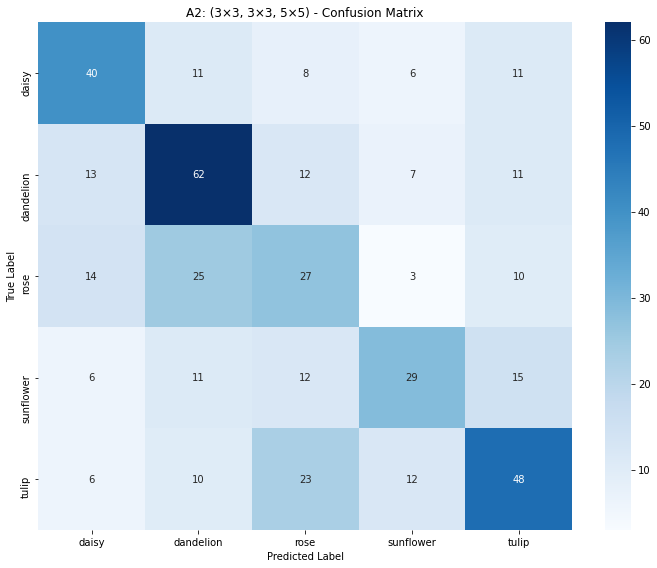


############################################################
Running A3: (3×3, 5×5, 5×5)
############################################################

A3: (3×3, 5×5, 5×5)
Model Summary:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_24 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 40, 40, 32)        12832     

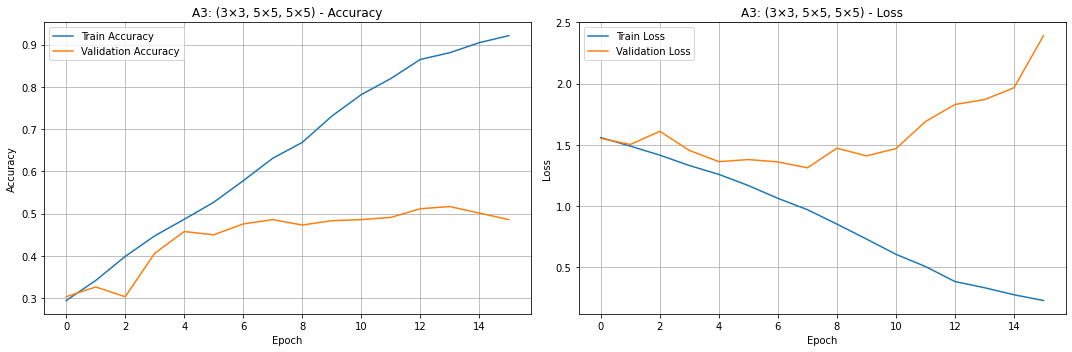

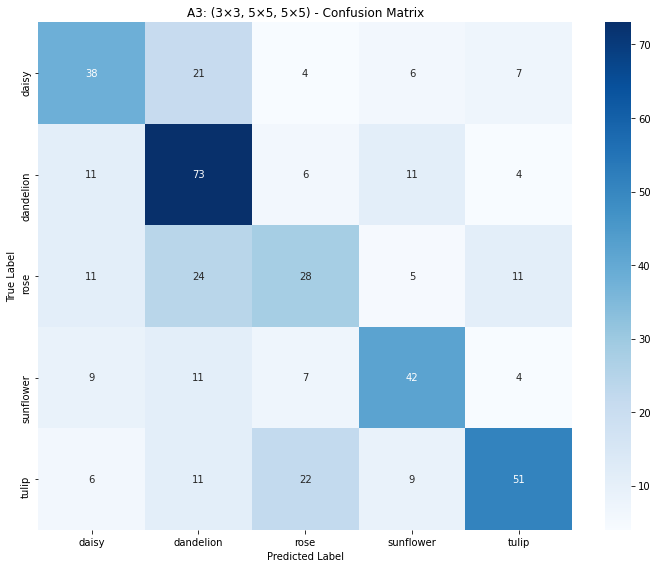


############################################################
Running A4: (5×5, 5×5, 5×5)
############################################################

A4: (5×5, 5×5, 5×5)
Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 80, 80, 16)        416       
                                                                 
 activation_28 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 40, 40, 32)        12832     

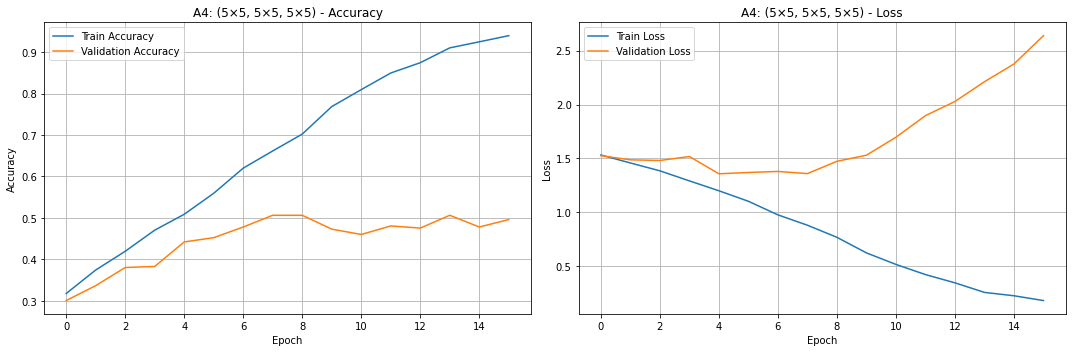

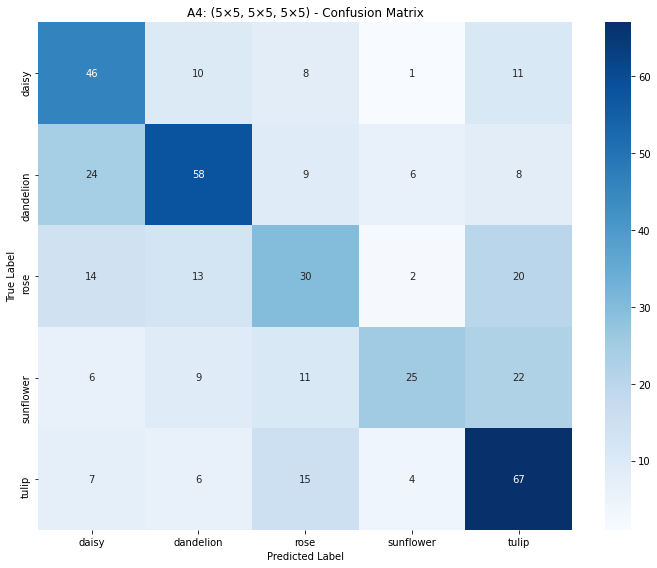


Best Kernel Configuration: A1: (3×3, 3×3, 3×3) with accuracy: 0.5509


In [8]:
# Dictionary to store all experiment results
experiment_results = {}

# Experiment A: Kernel Size Analysis
kernel_experiments = [
    ([3, 3, 3], "A1: (3×3, 3×3, 3×3)"),
    ([3, 3, 5], "A2: (3×3, 3×3, 5×5)"),
    ([3, 5, 5], "A3: (3×3, 5×5, 5×5)"),
    ([5, 5, 5], "A4: (5×5, 5×5, 5×5)")
]

for kernel_sizes, exp_name in kernel_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=kernel_sizes,
        filters=[16, 32, 64],
        pooling_type='max',
        activation='relu',
        num_fc_layers=1,
        regularization='dropout',
        dropout_rate=0.1,
        use_batch_norm=False
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    # Store results
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    # Plot history
    plot_history(history, exp_name)
    
    # Plot confusion matrix
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

# Find best kernel size configuration
best_kernel_exp = max([(k, v['test_accuracy']) for k, v in experiment_results.items()], key=lambda x: x[1])
print(f"\n{'='*60}")
print(f"Best Kernel Configuration: {best_kernel_exp[0]} with accuracy: {best_kernel_exp[1]:.4f}")
print(f"{'='*60}")

## 8. Experiment B: Number of Fully Connected Layers
Testing 2 and 3 FC layers with best kernel configuration from Experiment A


############################################################
Running B1: 2 FC Layers
############################################################

B1: 2 FC Layers
Model Summary:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_32 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 32)        4640      
       

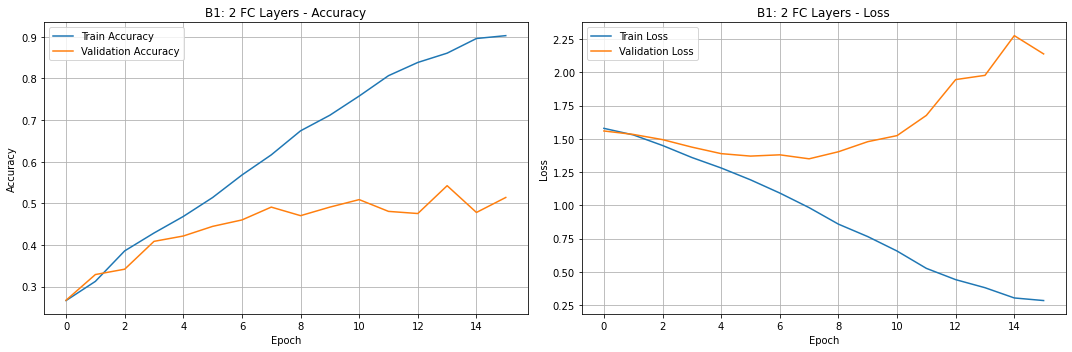

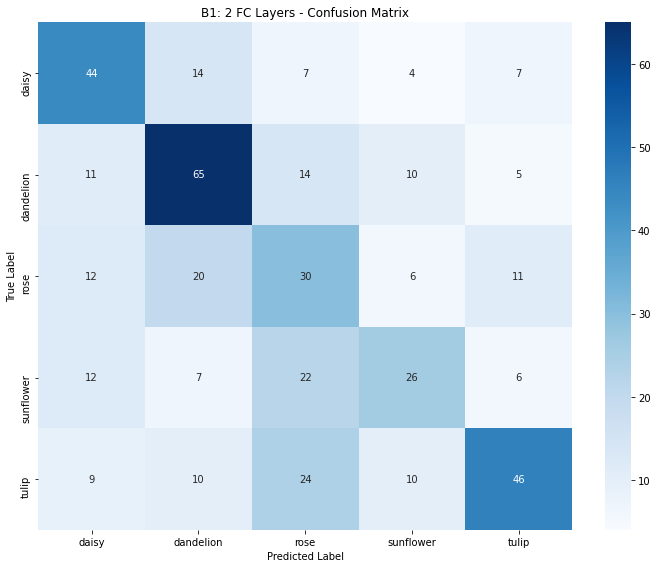


############################################################
Running B2: 3 FC Layers
############################################################

B2: 3 FC Layers
Model Summary:
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_37 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 40, 40, 32)        4640      
       

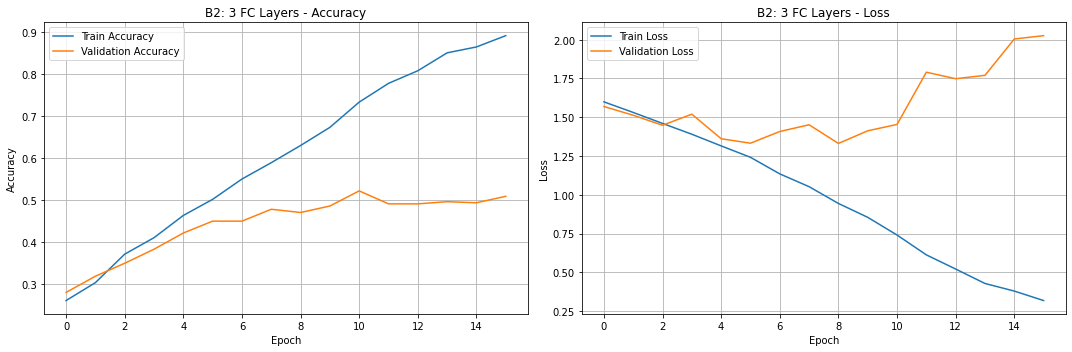

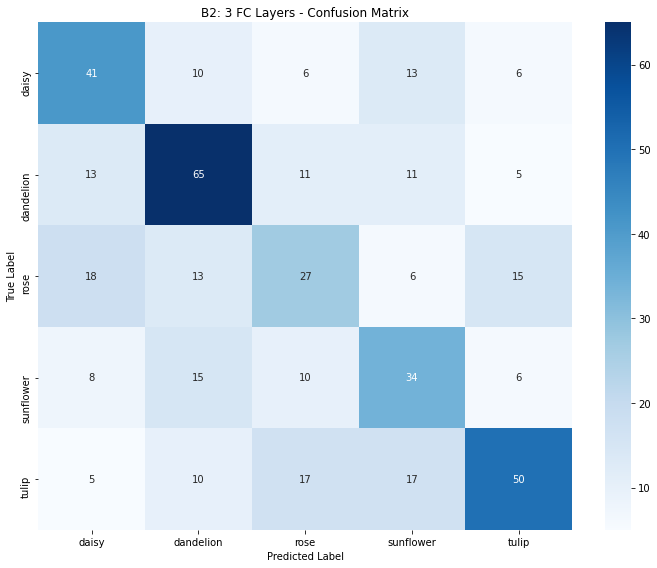

In [9]:
# Extract best kernel configuration from Experiment A
best_kernel_config = [3, 3, 3]  # This will be determined by results above

# Experiment B: Fully Connected Layers
fc_experiments = [
    (2, "B1: 2 FC Layers"),
    (3, "B2: 3 FC Layers")
]

for num_fc, exp_name in fc_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=best_kernel_config,
        filters=[16, 32, 64],
        pooling_type='max',
        activation='relu',
        num_fc_layers=num_fc,
        regularization='dropout',
        dropout_rate=0.1,
        use_batch_norm=False
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    plot_history(history, exp_name)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

## 9. Experiment C: Pooling Type Comparison
Testing Average Pooling vs Max Pooling


############################################################
Running C1: Average Pooling
############################################################

C1: Average Pooling
Model Summary:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_43 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 average_pooling2d (AverageP  (None, 40, 40, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout_43 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 40, 40, 32)        4640     

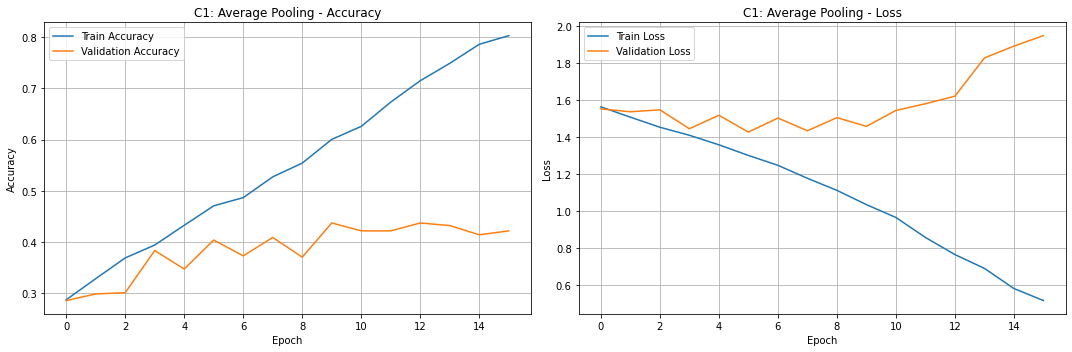

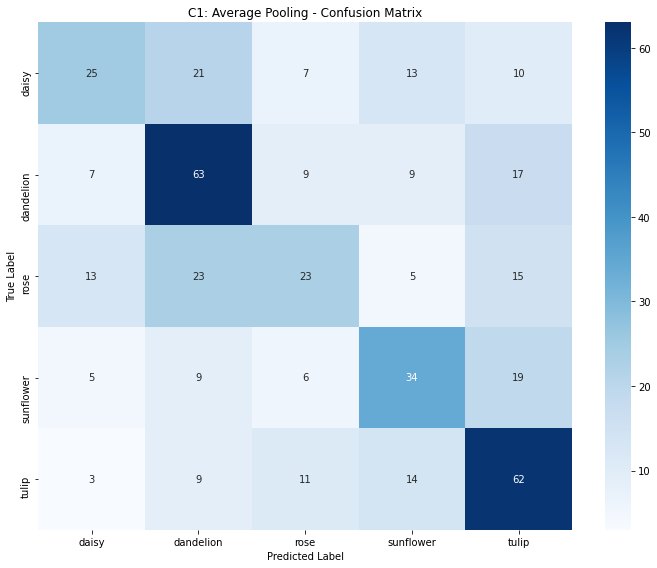

In [10]:
# Experiment C: Pooling Type
pooling_experiments = [
    ('average', "C1: Average Pooling")
]

for pooling_type, exp_name in pooling_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=best_kernel_config,
        filters=[16, 32, 64],
        pooling_type=pooling_type,
        activation='relu',
        num_fc_layers=1,
        regularization='dropout',
        dropout_rate=0.1,
        use_batch_norm=False
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    plot_history(history, exp_name)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

## 10. Experiment D: Activation Function Comparison
Testing Sigmoid, ReLU, and Leaky ReLU


############################################################
Running D1: Sigmoid
############################################################

D1: Sigmoid
Model Summary:
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_55 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 40, 40, 32)        4640      
              

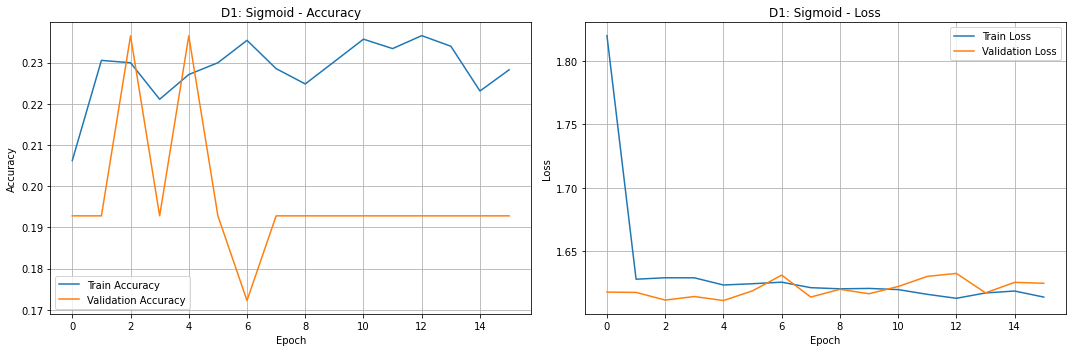

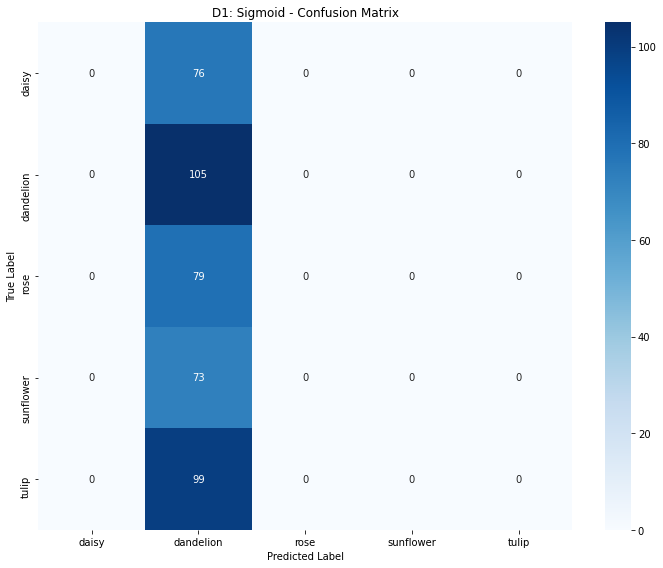


############################################################
Running D2: ReLU
############################################################

D2: ReLU
Model Summary:
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_59 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_63 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 40, 40, 32)        4640      
                    

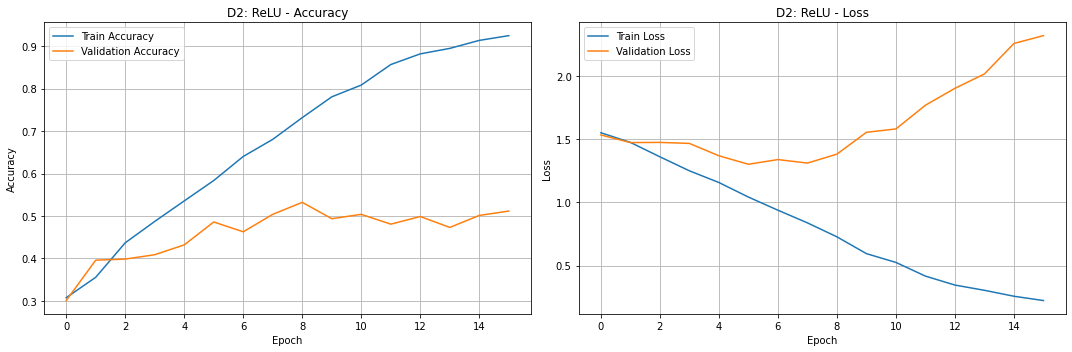

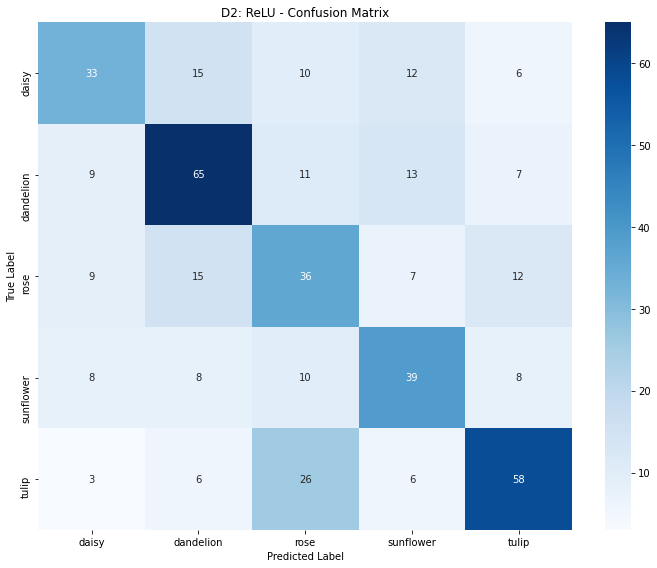


############################################################
Running D3: Leaky ReLU
############################################################

D3: Leaky ReLU
Model Summary:
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 40, 40, 32)        4640      
        

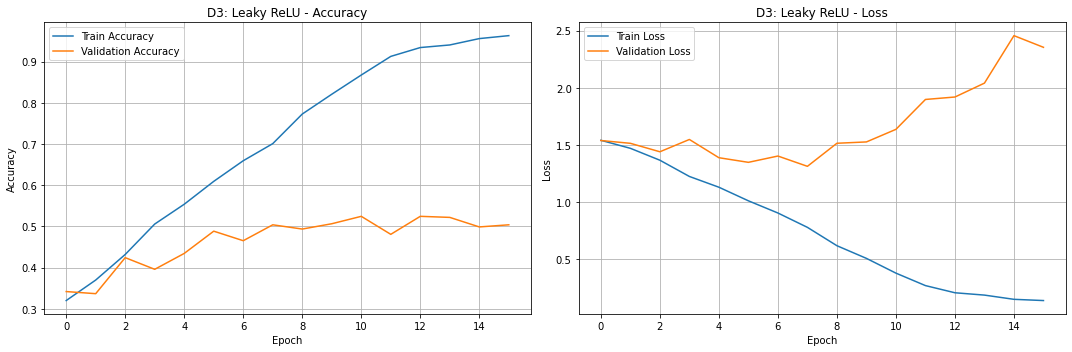

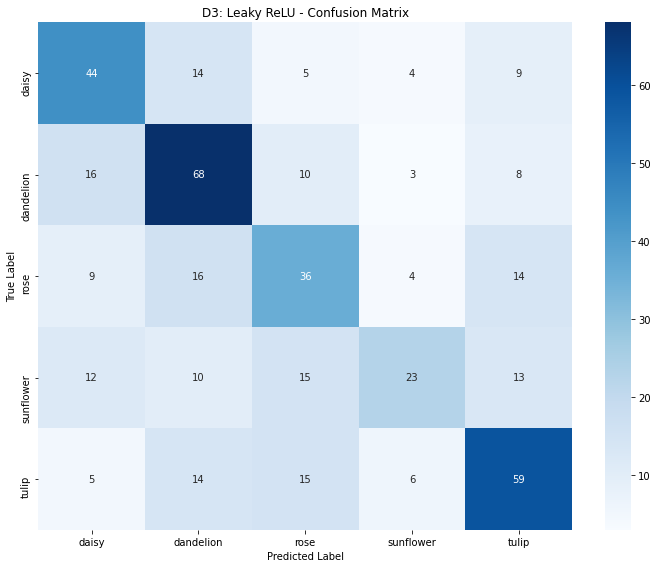

In [12]:
# Experiment D: Activation Functions
activation_experiments = [
    ('sigmoid', "D1: Sigmoid"),
    ('relu', "D2: ReLU"),
    ('leaky_relu', "D3: Leaky ReLU")
]

for activation, exp_name in activation_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=best_kernel_config,
        filters=[16, 32, 64],
        pooling_type='max',
        activation=activation,
        num_fc_layers=1,
        regularization='dropout',
        dropout_rate=0.1,
        use_batch_norm=False
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    plot_history(history, exp_name)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

## 11. Experiment E: Regularization Techniques
Testing different regularization approaches


############################################################
Running E1: Dropout 0.25
############################################################

E1: Dropout 0.25
Model Summary:
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_63 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_71 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 40, 40, 32)        4640      
    

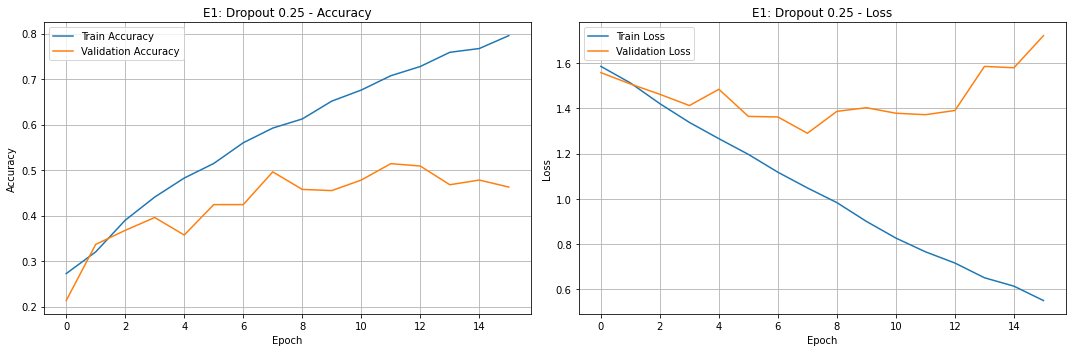

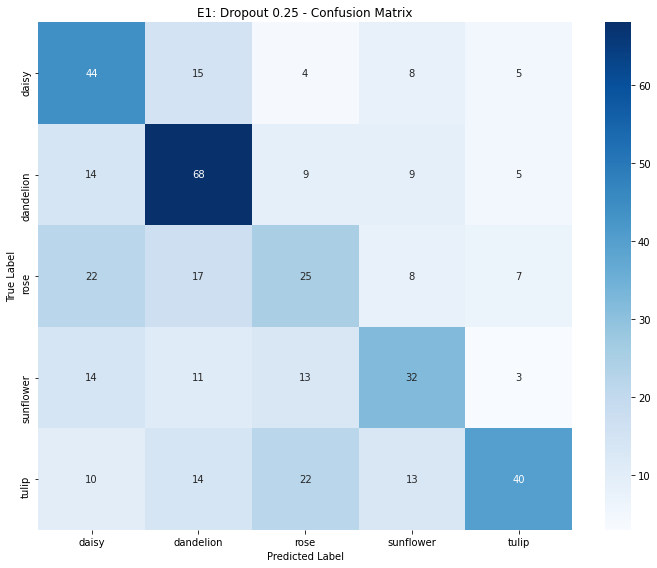


############################################################
Running E2: Batch Normalization
############################################################

E2: Batch Normalization
Model Summary:
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_67 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 40, 40, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 32)       1

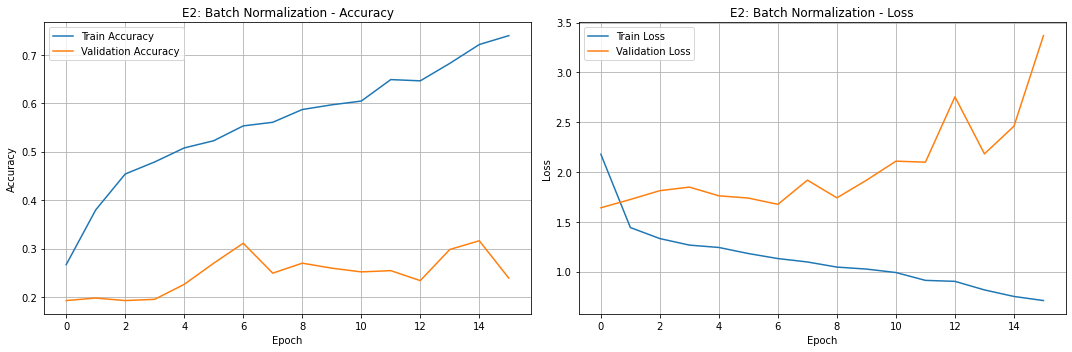

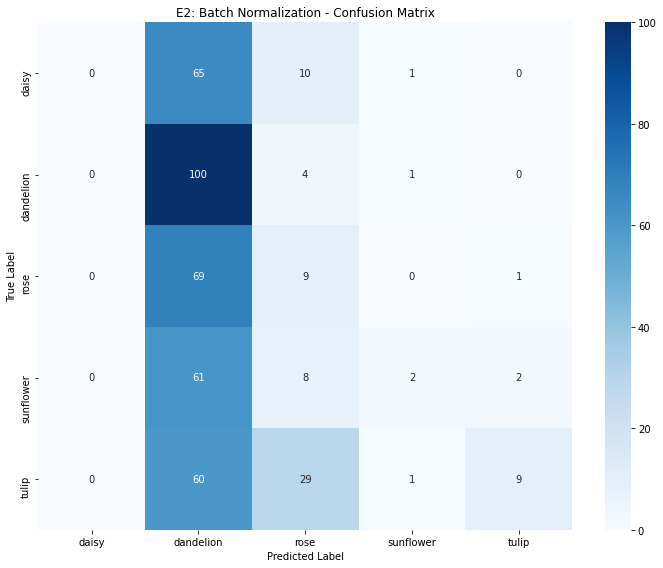


############################################################
Running E3: Dropout 0.1 + Batch Norm
############################################################

E3: Dropout 0.1 + Batch Norm
Model Summary:
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_71 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_75 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 40, 40, 32

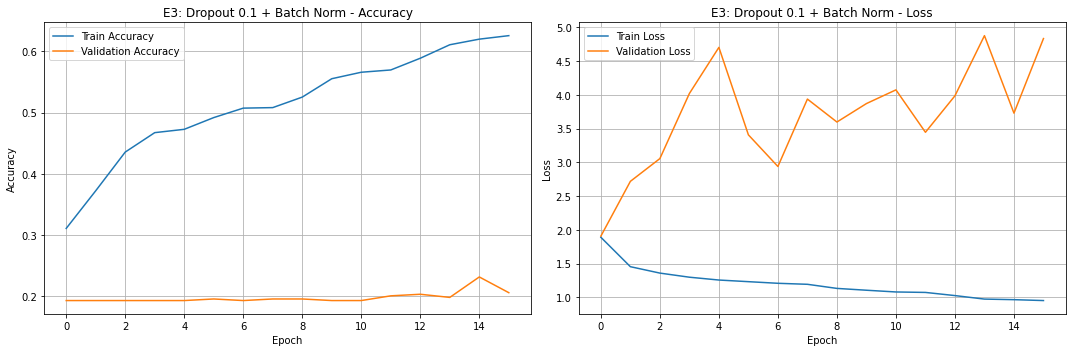

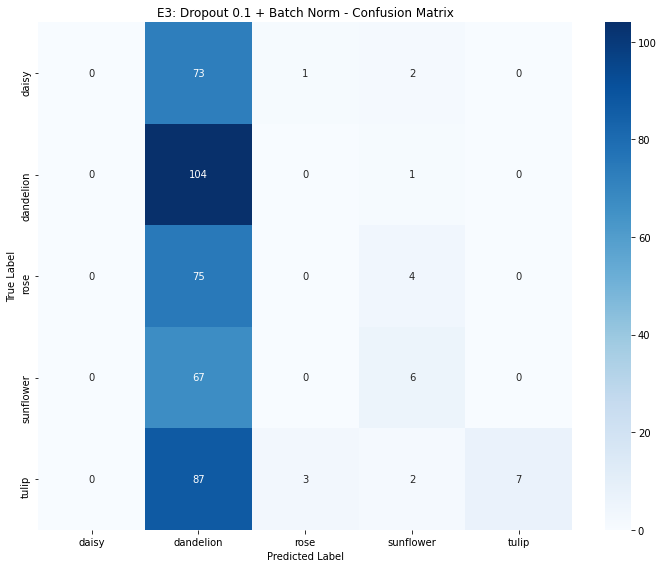

In [13]:
# Experiment E: Regularization Techniques
regularization_experiments = [
    (0.25, 'dropout', False, "E1: Dropout 0.25"),
    (0.1, 'batch_norm', True, "E2: Batch Normalization"),
    (0.1, 'both', True, "E3: Dropout 0.1 + Batch Norm")
]

for dropout_rate, reg_type, use_bn, exp_name in regularization_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=best_kernel_config,
        filters=[16, 32, 64],
        pooling_type='max',
        activation='relu',
        num_fc_layers=1,
        regularization=reg_type,
        dropout_rate=dropout_rate,
        use_batch_norm=use_bn
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    plot_history(history, exp_name)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

## 12. Experiment F: Adding More Convolution Layers
Testing [1, 2, 3] additional convolution layers and comparing trainable parameters and training time


############################################################
Running F1: 4 Conv Layers (3 base + 1)
############################################################

F1: 4 Conv Layers (3 base + 1)
Model Summary:
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_75 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_79 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 40, 40

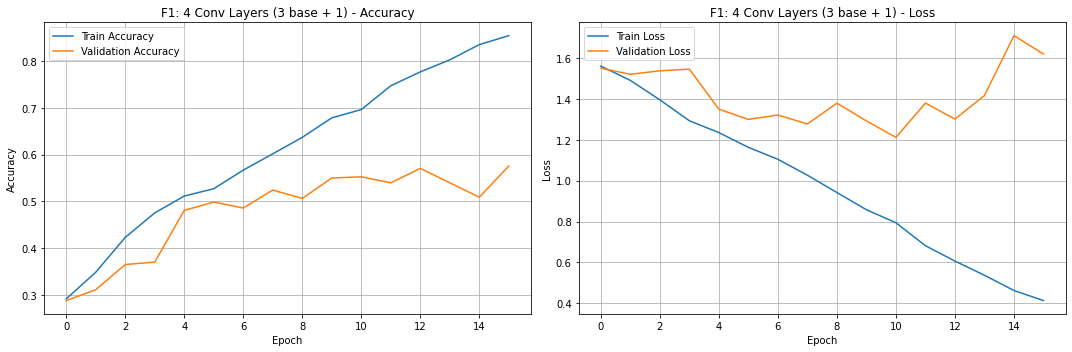

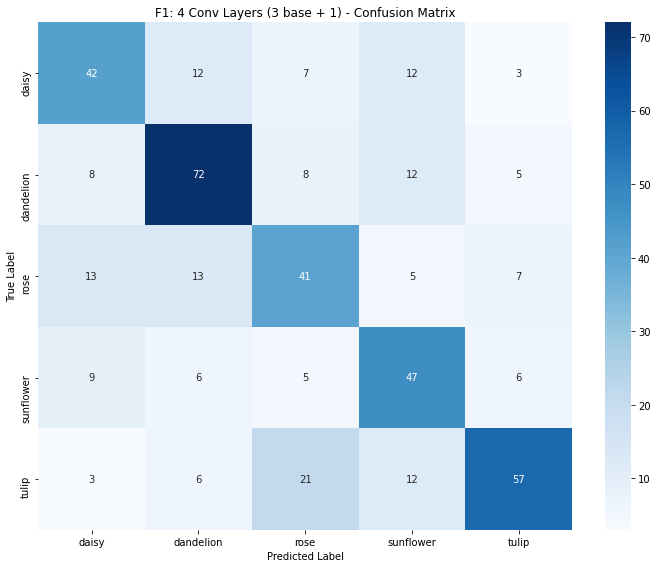


############################################################
Running F2: 5 Conv Layers (3 base + 2)
############################################################

F2: 5 Conv Layers (3 base + 2)
Model Summary:
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_80 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_84 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 40, 40

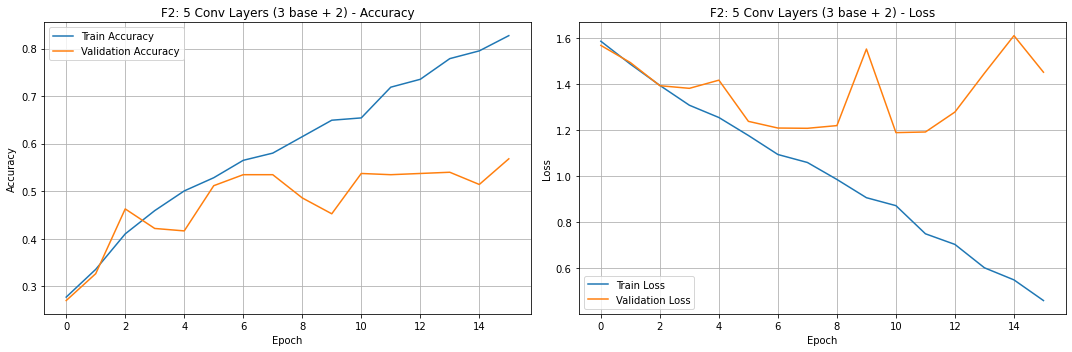

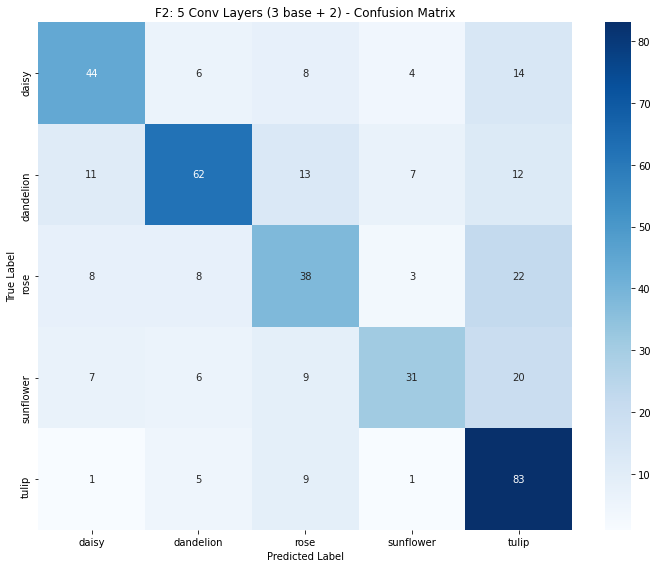


############################################################
Running F3: 6 Conv Layers (3 base + 3)
############################################################

F3: 6 Conv Layers (3 base + 3)
Model Summary:
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_86 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_90 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 40, 40

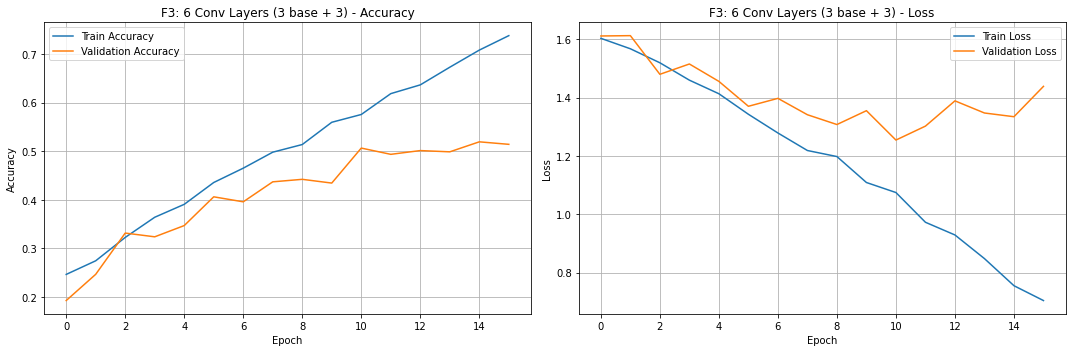

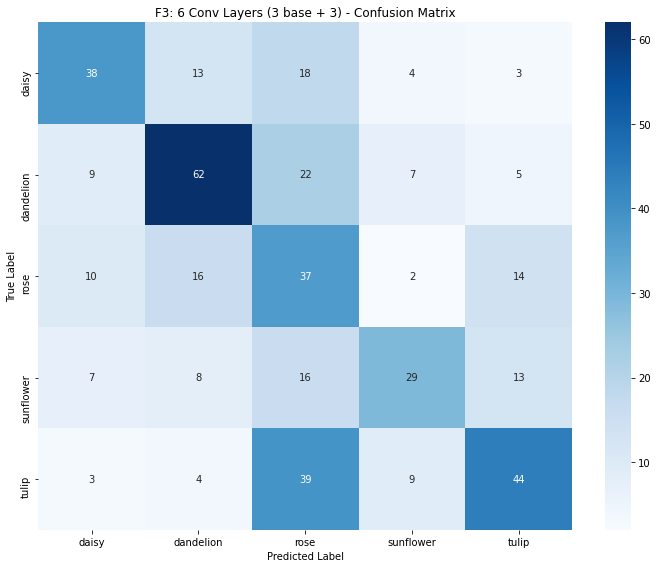


EXPERIMENT F: Comparison of Conv Layers, Parameters, and Training Time
F1: 4 Conv Layers (3 base + 1):
  Trainable Parameters: 507,525
  Training Time: 17.03 seconds
  Test Accuracy: 0.5995

F2: 5 Conv Layers (3 base + 2):
  Trainable Parameters: 524,165
  Training Time: 19.45 seconds
  Test Accuracy: 0.5972

F3: 6 Conv Layers (3 base + 3):
  Trainable Parameters: 1,638,789
  Training Time: 20.43 seconds
  Test Accuracy: 0.4861



In [14]:
# Experiment F: Adding More Convolution Layers
conv_layer_experiments = [
    ([3, 3, 3, 3], [16, 32, 64, 128], "F1: 4 Conv Layers (3 base + 1)"),
    ([3, 3, 3, 3, 3], [16, 32, 64, 128, 256], "F2: 5 Conv Layers (3 base + 2)"),
    ([3, 3, 3, 3, 3, 3], [16, 32, 64, 128, 256, 512], "F3: 6 Conv Layers (3 base + 3)")
]

for kernel_config, filter_config, exp_name in conv_layer_experiments:
    print(f"\n{'#'*60}")
    print(f"Running {exp_name}")
    print(f"{'#'*60}")
    
    model = build_cnn_model(
        input_shape=X_train.shape[1:],
        kernel_sizes=kernel_config,
        filters=filter_config,
        pooling_type='max',
        activation='relu',
        num_fc_layers=1,
        regularization='dropout',
        dropout_rate=0.1,
        use_batch_norm=False
    )
    
    history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
        model, X_train, y_train_cat, X_test, y_test_cat,
        epochs=16, batch_size=32, experiment_name=exp_name
    )
    
    experiment_results[exp_name] = {
        'history': history,
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'f1_score': f1,
        'train_time': train_time,
        'predictions': preds,
        'params': model.count_params()
    }
    
    plot_history(history, exp_name)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)
    plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

# Compare trainable parameters and training time
print("\n" + "="*80)
print("EXPERIMENT F: Comparison of Conv Layers, Parameters, and Training Time")
print("="*80)
f_results = {k: v for k, v in experiment_results.items() if k.startswith('F')}
for exp_name, results in f_results.items():
    print(f"{exp_name}:")
    print(f"  Trainable Parameters: {results['params']:,}")
    print(f"  Training Time: {results['train_time']:.2f} seconds")
    print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
    print()

## 13. Experiment G: Best Model with Color Images
Repeat best configuration with RGB color images

Loading color images...
Loading images from: /home/Assignment-05/flowers
Loading 764 images from daisy...
Loading 1052 images from dandelion...
Loading 784 images from rose...
Loading 733 images from sunflower...
Loading 984 images from tulip...

Total images loaded: 4317
Image shape: (4317, 80, 80, 3)
Labels shape: (4317,)
daisy: 764 images
dandelion: 1052 images
rose: 784 images
sunflower: 733 images
tulip: 984 images

Color Training set: (3885, 80, 80, 3)
Color Test set: (432, 80, 80, 3)


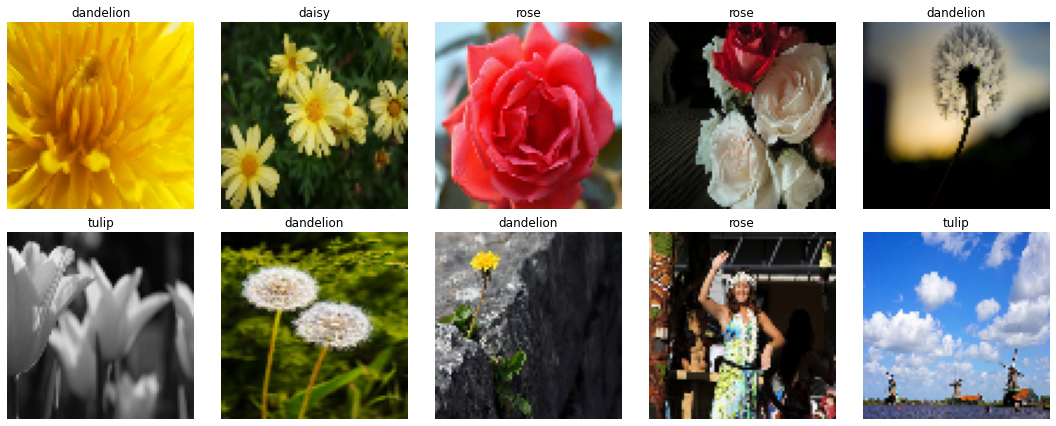


############################################################
Running G1: Best Model on Color Images
############################################################

G1: Best Model on Color Images
Model Summary:
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 80, 80, 16)        448       
                                                                 
 activation_93 (Activation)  (None, 80, 80, 16)        0         
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_97 (Dropout)        (None, 40, 40, 16)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 40, 40

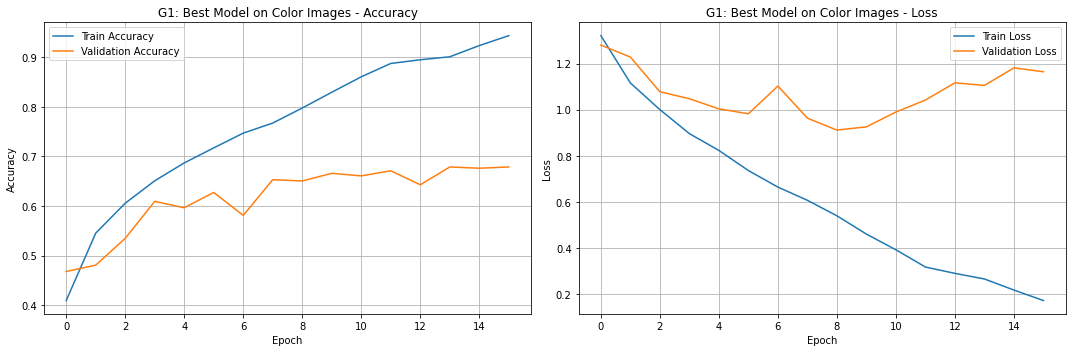

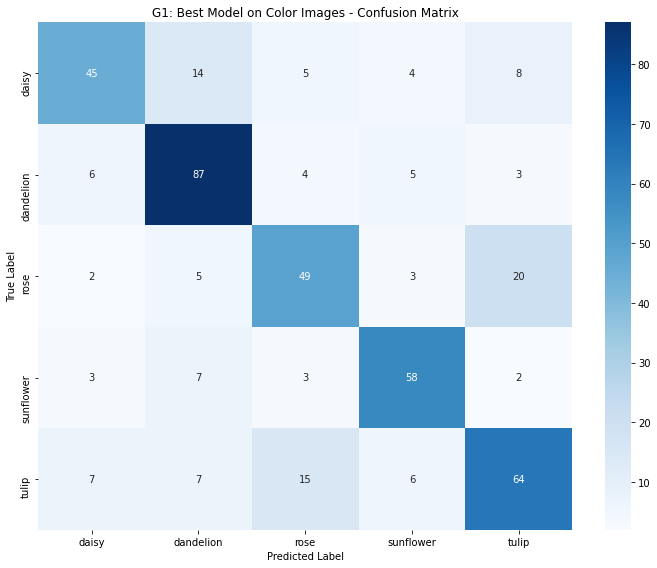

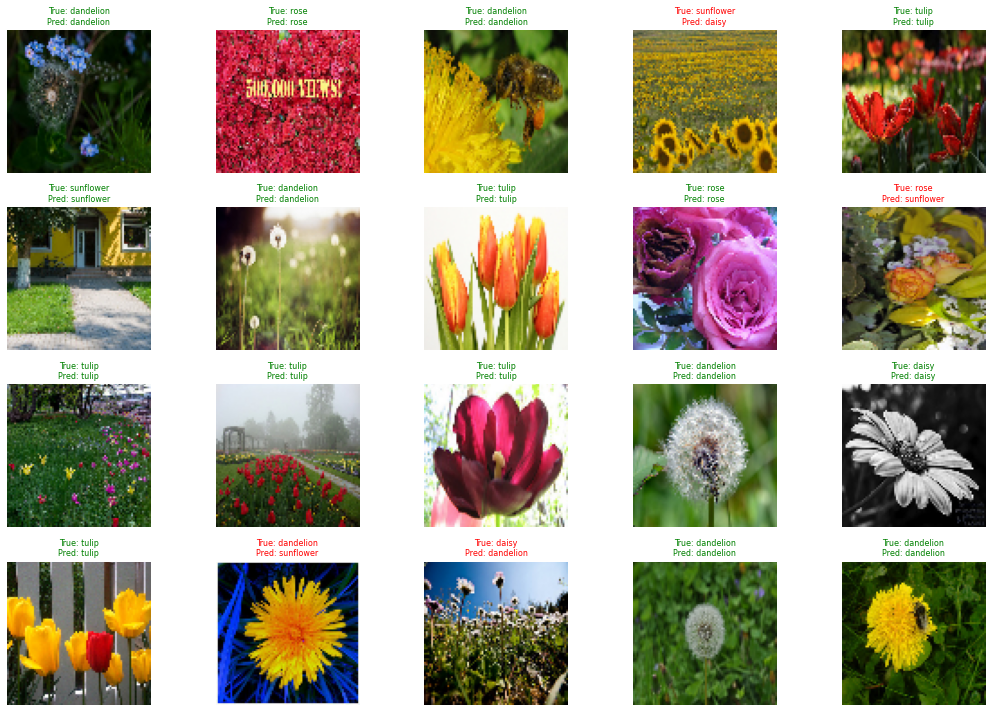

In [15]:
# Load color images
print("Loading color images...")
X_color, y_color, _ = load_and_preprocess_images(path, grayscale=False, reduce_size=False)

# Split data
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(
    X_color, y_color, test_size=0.1, random_state=42, stratify=y_color
)

y_train_color_cat = to_categorical(y_train_color, num_classes=5)
y_test_color_cat = to_categorical(y_test_color, num_classes=5)

print(f"\nColor Training set: {X_train_color.shape}")
print(f"Color Test set: {X_test_color.shape}")

# Visualize color images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_color[i])
    plt.title(f'{class_names[y_test_color[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Train with best configuration on color images
exp_name = "G1: Best Model on Color Images"
print(f"\n{'#'*60}")
print(f"Running {exp_name}")
print(f"{'#'*60}")

model_color = build_cnn_model(
    input_shape=X_train_color.shape[1:],
    kernel_sizes=best_kernel_config,
    filters=[16, 32, 64],
    pooling_type='max',
    activation='relu',
    num_fc_layers=1,
    regularization='dropout',
    dropout_rate=0.1,
    use_batch_norm=False
)

history, test_acc, test_loss, preds, train_time, f1 = train_and_evaluate(
    model_color, X_train_color, y_train_color_cat, X_test_color, y_test_color_cat,
    epochs=16, batch_size=32, experiment_name=exp_name
)

experiment_results[exp_name] = {
    'history': history,
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'f1_score': f1,
    'train_time': train_time,
    'predictions': preds,
    'params': model_color.count_params()
}

plot_history(history, exp_name)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test_color_cat, axis=1)
plot_confusion_matrix(y_true, y_pred, class_names, exp_name)

# Visualize some predictions
plt.figure(figsize=(15, 10))
indices = np.random.choice(len(X_test_color), 20, replace=False)
for idx, i in enumerate(indices):
    plt.subplot(4, 5, idx + 1)
    plt.imshow(X_test_color[i])
    pred_label = np.argmax(preds[i])
    true_label = y_test_color[i]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}', 
              color=color, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 14. Comprehensive Results Comparison
Bar graphs comparing accuracy, F1 scores, and training times across all experiments

COMPREHENSIVE RESULTS SUMMARY
                     Experiment  Test Accuracy  F1 Score  Training Time (s)  Parameters
            A1: (3×3, 3×3, 3×3)       0.550926  0.550323          15.110447      843269
            A2: (3×3, 3×3, 5×5)       0.476852  0.475478          15.982179      876037
            A3: (3×3, 5×5, 5×5)       0.537037  0.533564          15.916156      884229
            A4: (5×5, 5×5, 5×5)       0.523148  0.517409          16.225138      884485
                B1: 2 FC Layers       0.488426  0.489000          16.602356      851205
                B2: 3 FC Layers       0.502315  0.501603          16.495131      855365
            C1: Average Pooling       0.479167  0.469295          15.312929      843269
                    D1: Sigmoid       0.243056  0.095050          15.067201      843269
                       D2: ReLU       0.534722  0.536122          14.802805      843269
                 D3: Leaky ReLU       0.532407  0.526134          14.814753      843269
  

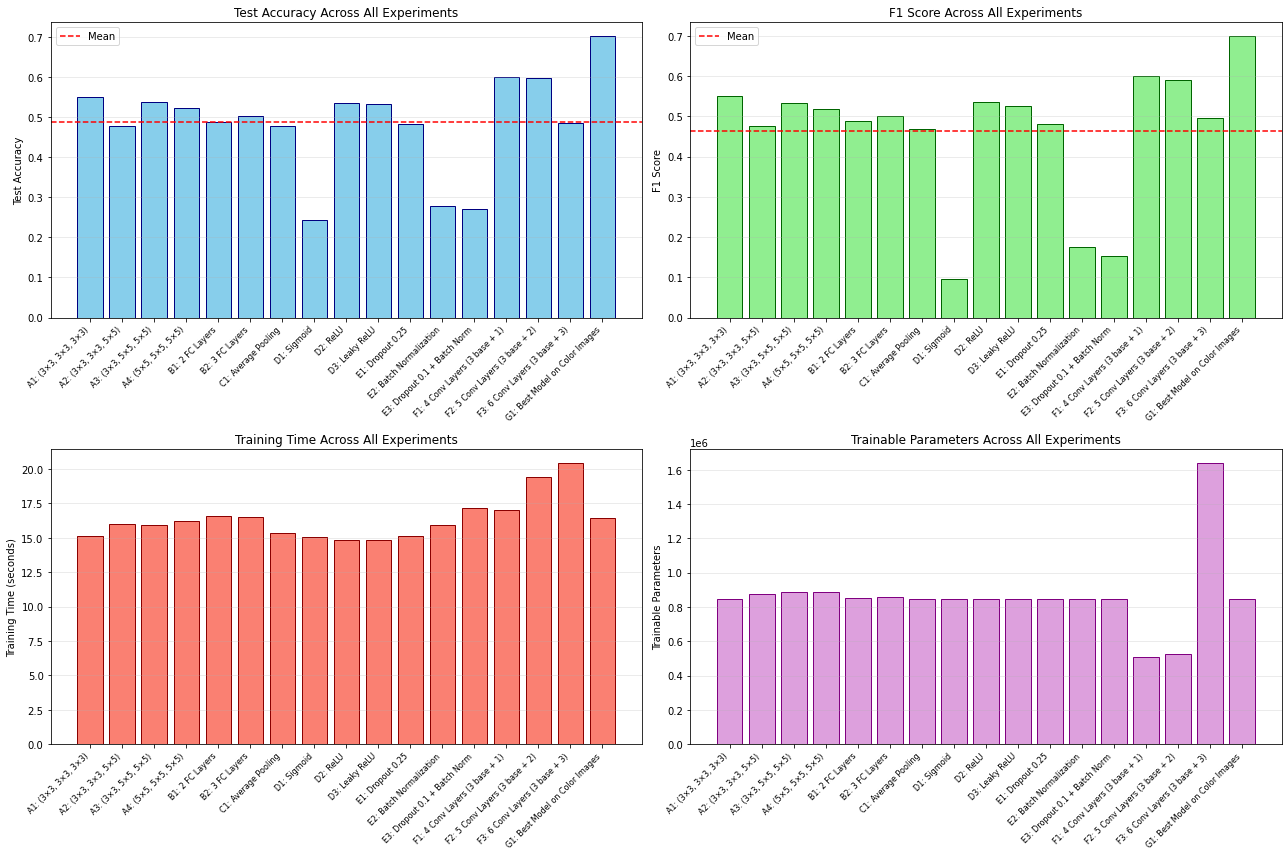


BEST MODEL: G1: Best Model on Color Images
Test Accuracy: 0.7014
F1 Score: 0.6987
Training Time: 16.44 seconds
Trainable Parameters: 843,557


In [16]:
# Create comprehensive comparison
exp_names = list(experiment_results.keys())
accuracies = [experiment_results[exp]['test_accuracy'] for exp in exp_names]
f1_scores = [experiment_results[exp]['f1_score'] for exp in exp_names]
train_times = [experiment_results[exp]['train_time'] for exp in exp_names]
params = [experiment_results[exp]['params'] for exp in exp_names]

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    'Experiment': exp_names,
    'Test Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Training Time (s)': train_times,
    'Parameters': params
})

print("="*100)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Plot accuracy comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Accuracy bar plot
axes[0, 0].bar(range(len(exp_names)), accuracies, color='skyblue', edgecolor='navy')
axes[0, 0].set_xticks(range(len(exp_names)))
axes[0, 0].set_xticklabels(exp_names, rotation=45, ha='right', fontsize=8)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy Across All Experiments')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=np.mean(accuracies), color='r', linestyle='--', label='Mean')
axes[0, 0].legend()

# F1 Score bar plot
axes[0, 1].bar(range(len(exp_names)), f1_scores, color='lightgreen', edgecolor='darkgreen')
axes[0, 1].set_xticks(range(len(exp_names)))
axes[0, 1].set_xticklabels(exp_names, rotation=45, ha='right', fontsize=8)
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('F1 Score Across All Experiments')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=np.mean(f1_scores), color='r', linestyle='--', label='Mean')
axes[0, 1].legend()

# Training time bar plot
axes[1, 0].bar(range(len(exp_names)), train_times, color='salmon', edgecolor='darkred')
axes[1, 0].set_xticks(range(len(exp_names)))
axes[1, 0].set_xticklabels(exp_names, rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].set_title('Training Time Across All Experiments')
axes[1, 0].grid(axis='y', alpha=0.3)

# Parameters bar plot
axes[1, 1].bar(range(len(exp_names)), params, color='plum', edgecolor='purple')
axes[1, 1].set_xticks(range(len(exp_names)))
axes[1, 1].set_xticklabels(exp_names, rotation=45, ha='right', fontsize=8)
axes[1, 1].set_ylabel('Trainable Parameters')
axes[1, 1].set_title('Trainable Parameters Across All Experiments')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find and display best model
best_exp = max(experiment_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\n{'='*100}")
print(f"BEST MODEL: {best_exp[0]}")
print(f"{'='*100}")
print(f"Test Accuracy: {best_exp[1]['test_accuracy']:.4f}")
print(f"F1 Score: {best_exp[1]['f1_score']:.4f}")
print(f"Training Time: {best_exp[1]['train_time']:.2f} seconds")
print(f"Trainable Parameters: {best_exp[1]['params']:,}")
print(f"{'='*100}")

## 15. MNIST Comparison (Assignment 4)
Train MNIST model with best flower classification parameters and compare results

Loading MNIST dataset...
MNIST Training set: (60000, 80, 80, 1)
MNIST Test set: (10000, 80, 80, 1)


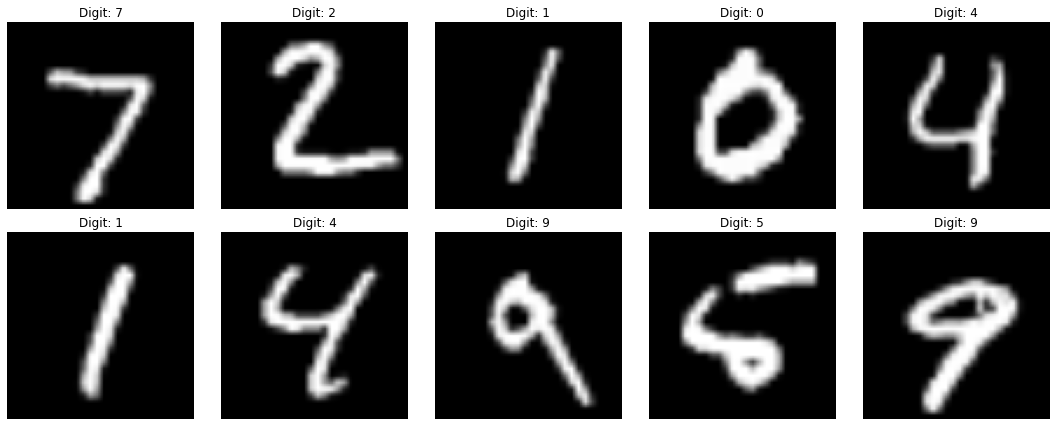

In [17]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist

print("Loading MNIST dataset...")
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

# Preprocess MNIST data
X_train_mnist = X_train_mnist.astype('float32') / 255.0
X_test_mnist = X_test_mnist.astype('float32') / 255.0

# Resize to 80x80 to match flower images
X_train_mnist_resized = np.array([cv2.resize(img, (80, 80)) for img in X_train_mnist])
X_test_mnist_resized = np.array([cv2.resize(img, (80, 80)) for img in X_test_mnist])

# Add channel dimension
X_train_mnist_resized = X_train_mnist_resized.reshape(-1, 80, 80, 1)
X_test_mnist_resized = X_test_mnist_resized.reshape(-1, 80, 80, 1)

# Convert labels to categorical
y_train_mnist_cat = to_categorical(y_train_mnist, num_classes=10)
y_test_mnist_cat = to_categorical(y_test_mnist, num_classes=10)

print(f"MNIST Training set: {X_train_mnist_resized.shape}")
print(f"MNIST Test set: {X_test_mnist_resized.shape}")

# Visualize MNIST samples
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_mnist_resized[i].squeeze(), cmap='gray')
    plt.title(f'Digit: {y_test_mnist[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


############################################################
Running MNIST: Best Flower Configuration
############################################################

MNIST: Best Flower Configuration
Model Summary:
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 80, 80, 16)        160       
                                                                 
 activation_101 (Activation)  (None, 80, 80, 16)       0         
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 dropout_105 (Dropout)       (None, 40, 40, 16)        0         
                                                                 
 conv2d_82 (Conv2D)          (None, 40

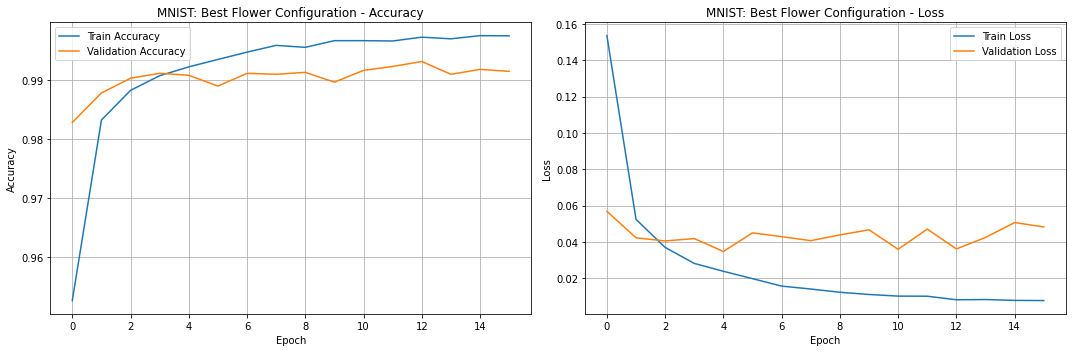

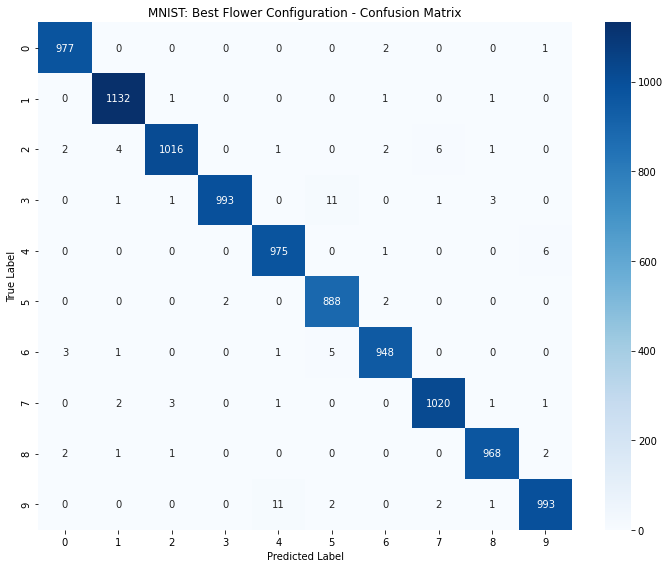

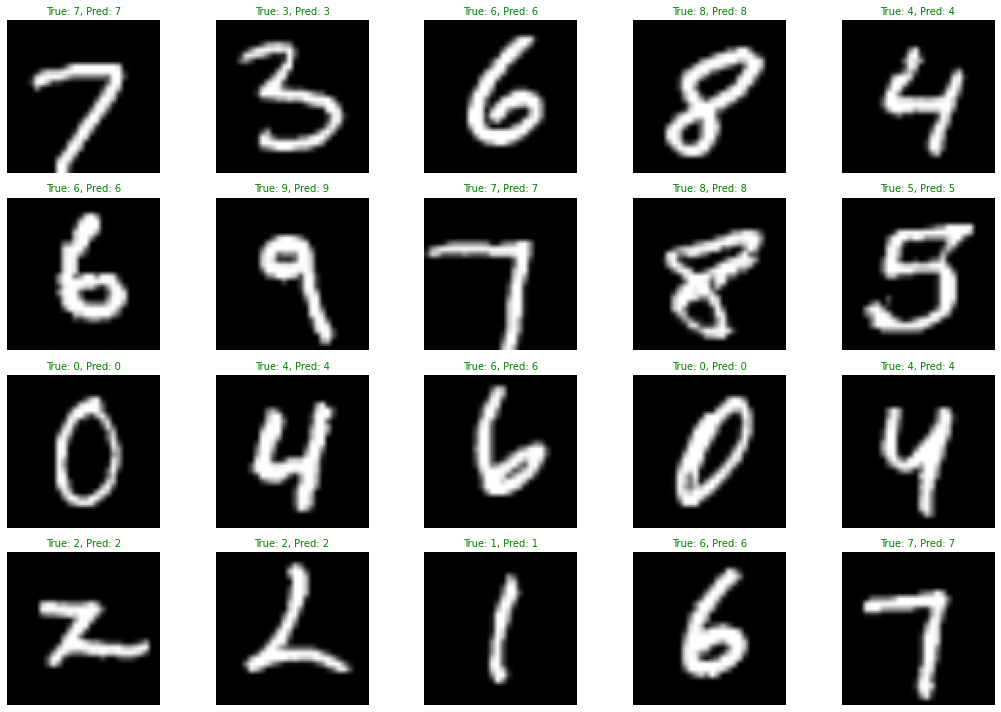


MNIST vs Flower Classification Comparison
MNIST Test Accuracy: 0.9910
MNIST F1 Score: 0.9910
Best Flower Model Accuracy: 0.7014
Best Flower Model F1 Score: 0.6987


In [19]:
# Train MNIST model with best flower configuration
exp_name = "MNIST: Best Flower Configuration"
print(f"\n{'#'*60}")
print(f"Running {exp_name}")
print(f"{'#'*60}")

model_mnist = build_cnn_model(
    input_shape=(80, 80, 1),
    kernel_sizes=best_kernel_config,
    filters=[16, 32, 64],
    pooling_type='max',
    activation='relu',
    num_fc_layers=1,
    regularization='dropout',
    dropout_rate=0.1,
    use_batch_norm=False,
    num_classes=10
)

history_mnist, test_acc_mnist, test_loss_mnist, preds_mnist, train_time_mnist, f1_mnist = train_and_evaluate(
    model_mnist, X_train_mnist_resized, y_train_mnist_cat, X_test_mnist_resized, y_test_mnist_cat,
    epochs=16, batch_size=32, experiment_name=exp_name
)

plot_history(history_mnist, exp_name)

# Confusion matrix for MNIST
y_pred_mnist = np.argmax(preds_mnist, axis=1)
y_true_mnist = y_test_mnist

mnist_classes = [str(i) for i in range(10)]
plot_confusion_matrix(y_true_mnist, y_pred_mnist, mnist_classes, exp_name)

# Visualize predictions on MNIST
plt.figure(figsize=(15, 10))
indices = np.random.choice(len(X_test_mnist_resized), 20, replace=False)
for idx, i in enumerate(indices):
    plt.subplot(4, 5, idx + 1)
    plt.imshow(X_test_mnist_resized[i].squeeze(), cmap='gray')
    pred_label = np.argmax(preds_mnist[i])
    true_label = y_test_mnist[i]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'True: {true_label}, Pred: {pred_label}', color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("MNIST vs Flower Classification Comparison")
print(f"{'='*60}")
print(f"MNIST Test Accuracy: {test_acc_mnist:.4f}")
print(f"MNIST F1 Score: {f1_mnist:.4f}")
print(f"Best Flower Model Accuracy: {best_exp[1]['test_accuracy']:.4f}")
print(f"Best Flower Model F1 Score: {best_exp[1]['f1_score']:.4f}")
print(f"{'='*60}")